# Introduction / Business Problem

Beer is a major part of German culture. In 2012, Germany ranked third in Europe in terms of per-capita beer consumption, behind the Czech Republic and Austria. Germany is also famous for its beer festivals (e.g. Octoberfest in Munchen or Cannstatter Volksfest in Stuttgart). Thus, taking a glass of beer in the bar the evening seems to be a popular activity in Germany.

<div class="alert alert-block alert-success">
<b>Goal:</b> For this project, I decided to investigate the "bar"-business in Frankfurt am Main and find top-5 districts where it may be worth making a new bar.
</div>

Frankfurt is the most populous city in the German state of Hesse. Frankfurt is a global hub for commerce, culture, education, tourism and transportation, and rated as an "alpha world city" according to GaWC. <br>Sounds like a good candidate for the research!

The hospitality industry may be interested in the results of this project

# Data

For this research we need the following data:
1. Frankfurt districts (Stadtteile)
2. Their longitude and latitude
3. Their geometry (optional)
4. Information about the population density for each district
5. Information about the bars in Frankfurt (amount, longitude, latitude)

I will use the following services to exctract the data:

1. Parsing Wikipedia to get Frankfurt districts and information about the area and population which is used to calculated the population density ("https://de.wikipedia.org/wiki/Liste_der_Stadtteile_von_Frankfurt_am_Main"). 
2. Python Geocoder is used to get the latitude and longitude for each district. This coordinates will be later used in Foursquare API search/expolore query to find bars for each district.
3. Geometry of the districts will be downloaded as the .geojson file (https://offenedaten.frankfurt.de/dataset/85b38876-729c-4a78-910c-a52d5c6df8d2/resource/84dff094-ab75-431f-8c64-39606672f1da/download/ffmstadtteilewahlen.geojson)
4. Foursquare search/explore query API is used to find bars and their coordinates for each neighbourhood. The categoryId='4bf58dd8d48988d116941735' ('bars') 

<div class="alert alert-block alert-success">
<b>Plan:</b> Cluster Frankfurt districts based on the amount of bars and population density. Based on the clusterization, define districts-candidates for bars
</div>

## Imports

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.colors as colors
import matplotlib.cm as cm
import folium # map rendering library
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

## Import the data from Wiki to the pandas dataframe

In [2]:
url = "https://de.wikipedia.org/wiki/Liste_der_Stadtteile_von_Frankfurt_am_Main"
html_data = requests.get(url).text
soup = BeautifulSoup(html_data, "html.parser")
#table_contents = pd.DataFrame(columns = ['PostalCode', 'Borough','Neighborhood'])

for row in soup.find("tbody").find_all("tr"):
    page = requests.get(url)
    soup =  BeautifulSoup(page.content,"html.parser")
    table_contents=[]
    table=soup.find('table')
    for row in table.findAll('tr')[1:-1]:
        table_list = [i for i in row.text.split('\n') if i]
        if table_list[1]=='Flughafen':
            pass
        else:
            
            cell = {}
            cell['Name'] = table_list[1]
            cell['Area'] = table_list[2]
            cell['Population'] = table_list[3]
            #cell['City districts'] = table_list[2]
            #cell['Population density (Population/km²)'] = table_list[9]
        
            table_contents.append(cell)
            #print(row)
            #print(row.text.split('\n'))
df_2=pd.DataFrame(table_contents)

In [3]:
df_2

Name    Area Population
0             Altstadt   0,506      4.255
1           Innenstadt   1,491      6.550
2      Bahnhofsviertel   0,542      3.703
3          Westend-Süd   2,497     19.318
4         Westend-Nord   1,632     10.330
5         Nordend-West   3,100     30.975
6          Nordend-Ost   1,532     23.135
7               Ostend   5,564     29.744
8             Bornheim   2,786     30.761
9       Gutleutviertel   1,792      6.786
10              Gallus   4,517     42.012
11          Bockenheim   8,031     42.140
12  Sachsenhausen-Nord   4,235     32.824
13   Sachsenhausen-Süd  30,535     29.163
14             Oberrad   2,708     13.648
15           Niederrad   6,124     27.043
16          Schwanheim  14,773     20.576
17           Griesheim   5,100     23.569
18           Rödelheim   4,660     19.253
19              Hausen   1,246      7.349
20           Praunheim   5,153     16.729
21         Heddernheim   2,514     17.073
22         Niederursel   7,422     16.611
23            Ginnheim   2,695     16.826
24           Dornbusch   2,384     18.715
25         Eschersheim   3,232     15.323
26           Eckenheim   2,254     14.405
27        Preungesheim   3,680     15.775
28             Bonames   1,372      6.450
29         Berkersheim   3,185      3.881
30          Riederwald   1,074      5.000
31            Seckbach   7,999     10.473
32          Fechenheim   6,984     17.843
33              Höchst   4,597     16.103
34                Nied   3,708     19.785
35          Sindlingen   3,968      9.095
36           Zeilsheim   5,467     12.515
37     Unterliederbach   6,021     17.151
38          Sossenheim   5,919     16.175
39    Nieder-Erlenbach   8,367      4.686
40    Kalbach-Riedberg   6,580     22.170
41             Harheim   4,837      5.294
42     Nieder-Eschbach   6,348     11.462
43      Bergen-Enkheim  12,601     17.988
44    Frankfurter Berg   2,400      8.225

## Add latitude and longitude to the data table via geocoder

In [4]:
!pip install geocoder
import geocoder # import geocoder

You should consider upgrading via the 'c:\users\lenovo\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [5]:
latitudes_list = []
longitudes_list = []

for Name in zip(df_2['Name'].tolist()):

    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Frankfurt am main'.format(Name))
        lat_lng_coords = g.latlng
        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
        latitudes_list.append(latitude)
        longitudes_list.append(longitude)
        #print(Name, latitude, longitude)

# Define Lat/Long columns in the existing df and latitude/longitude lists as the source

df_2['Latitude'] = latitudes_list
df_2['Longitude'] = longitudes_list

Unfortunetely, some districts are too close to each other and show the same latitude and longitude. Then, we merge them in one district and later calculate the population density for the resulted districts.

In [6]:
Name=[]
Area=[]
Population=[]
Latitude=[]
Longitude=[]
Density=[]
df_merge=pd.DataFrame()
for i in range(df_2.shape[0]):
    if latitudes_list[i]==latitudes_list[i-1]:
        Name=Name[:-1]
        Area=Area[:-1]
        Population=Population[:-1]
        Latitude=Latitude[:-1]
        Longitude=Longitude[:-1]
        Name.append(df_2['Name'][i]+' & '+ df_2['Name'][i-1])
        Area.append(str(float(df_2['Area'][i].replace(',','.'))+float(df_2['Area'][i-1].replace(',','.'))))
        Population.append(str(float(df_2['Population'][i])+float(df_2['Population'][i-1])))
        Latitude.append(df_2['Latitude'][i])
        Longitude.append(df_2['Longitude'][i])
    else:
        Name.append(df_2['Name'][i])
        Area.append(df_2['Area'][i].replace(',','.'))
        Population.append(df_2['Population'][i])
        Latitude.append(df_2['Latitude'][i])
        Longitude.append(df_2['Longitude'][i])
        Density.append(str(float(df_2['Population'][i].replace('.',''))/float(df_2['Area'][i].replace(',','.'))))
df_merge['Name'] = Name
df_merge['Area (km²)'] = Area
df_merge['Population/10^3'] = Population
df_merge['Population density (Population/km²)'] = Density
df_merge['Latitude'] = Latitude
df_merge['Longitude'] = Longitude

In [7]:
df_merge.head()

Name Area (km²)     Population/10^3  \
0                    Altstadt      0.506               4.255   
1                  Innenstadt      1.491               6.550   
2             Bahnhofsviertel      0.542               3.703   
3  Westend-Nord & Westend-Süd      4.129  29.648000000000003   
4  Nordend-Ost & Nordend-West      4.632               54.11   

  Population density (Population/km²)  Latitude  Longitude  
0                   8409.090909090908  50.11138    8.68356  
1                   4393.024815560027  50.11374    8.67912  
2                    6832.10332103321  50.10782    8.66561  
3                   7736.483780536644  50.12418    8.66916  
4                   9991.935483870968  50.12874    8.68435

## Explore the map

In [8]:
address = 'Frankfurt am main'

geolocator = Nominatim(user_agent="frankfurt_explorer")
location = geolocator.geocode(address)
latitude_frankfurt = location.latitude
longitude_frankfurt = location.longitude
print('The geograpical coordinate of Frankfurt are {}, {}.'.format(latitude_frankfurt, longitude_frankfurt))

The geograpical coordinate of Frankfurt are 50.1106444, 8.6820917.


## Create a map

In [84]:
# create map of Frankfurt using latitude and longitude values
map_frankfurt = folium.Map(location=[latitude_frankfurt, longitude_frankfurt], zoom_start=11)

# add markers to map
for lat, lng, name in zip(df_merge['Latitude'], df_merge['Longitude'], df_merge['Name']):
    label = '{} '.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_frankfurt)  
    
map_frankfurt

## Define Foursquare Credentials and Version

In [10]:
CLIENT_ID = 'LKYXQ35UFXCD5W0TLX5VUDUQVVY2CRANMR3CPJ4SLSKPODYK' # your Foursquare ID
CLIENT_SECRET = 'R2FXPJOGGKEJMCXSUREU4HWQG3VFK54YTFFDEBSKX2DMEK2I' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LKYXQ35UFXCD5W0TLX5VUDUQVVY2CRANMR3CPJ4SLSKPODYK
CLIENT_SECRET:R2FXPJOGGKEJMCXSUREU4HWQG3VFK54YTFFDEBSKX2DMEK2I


## Find bar venues in Frankfurt via Foursquare

In [11]:
# Define test API fields
categoryId = '4bf58dd8d48988d116941735' #bars
near = 'Altstadt, Frankfurt am main' #Borough
query = 'beer garden'
radius = '800' # 0.5 mile in metres
print('OK!')

OK!


In [12]:
# Define API URL
from pandas import json_normalize

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryId, query, radius, LIMIT)
print(url)
results = requests.get(url).json()
items = results['response']['groups'][0]['items']
items
stokie_df = json_normalize(items) 
stokie_df.head()

https://api.foursquare.com/v2/venues/explore?client_id=LKYXQ35UFXCD5W0TLX5VUDUQVVY2CRANMR3CPJ4SLSKPODYK&client_secret=R2FXPJOGGKEJMCXSUREU4HWQG3VFK54YTFFDEBSKX2DMEK2I&ll=50.16626000000008,8.671340000000043&v=20180605&categoryId=4bf58dd8d48988d116941735&query=beer garden&radius=800&limit=100


referralId  reasons.count  \
0  e-0-511fc5f0e4b0f2db64d58eb7-0              0   
1  e-0-53348148498ec7816674dcfc-1              0   

                                       reasons.items  \
0  [{'summary': 'This spot is popular', 'type': '...   
1  [{'summary': 'This spot is popular', 'type': '...   

                   venue.id     venue.name  venue.location.lat  \
0  511fc5f0e4b0f2db64d58eb7  Old Man's Pub           50.165211   
1  53348148498ec7816674dcfc      Bergstübl           50.166741   

   venue.location.lng                      venue.location.labeledLatLngs  \
0            8.681124  [{'label': 'display', 'lat': 50.16521076615521...   
1            8.673647  [{'label': 'display', 'lat': 50.166741, 'lng':...   

   venue.location.distance venue.location.cc venue.location.city  \
0                      707                DE   Frankfurt am Main   
1                      172                DE   Frankfurt am Main   

  venue.location.state venue.location.country  \
0               Hessen            Deutschland   
1               Hessen            Deutschland   

                     venue.location.formattedAddress  \
0                   [Frankfurt am Main, Deutschland]   
1  [Berkersheimer Weg, Frankfurt am Main, Deutsch...   

                                    venue.categories  venue.photos.count  \
0  [{'id': '4bf58dd8d48988d116941735', 'name': 'B...                   0   
1  [{'id': '4bf58dd8d48988d11b941735', 'name': 'P...                   0   

  venue.photos.groups venue.location.address  
0                  []                    NaN  
1                  []      Berkersheimer Weg

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, categoryId, query, radius, LIMIT)
            
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['location']['formattedAddress'][0],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Address',
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
venues = getNearbyVenues(names=df_merge['Name'],
                                   latitudes=df_merge['Latitude'],
                                   longitudes=df_merge['Longitude']
                                  )

Altstadt
Innenstadt
Bahnhofsviertel
Westend-Nord & Westend-Süd
Nordend-Ost & Nordend-West
Ostend
Bornheim
Gutleutviertel
Gallus
Bockenheim
Sachsenhausen-Nord
Sachsenhausen-Süd
Oberrad
Niederrad
Schwanheim
Griesheim
Rödelheim
Hausen
Praunheim
Heddernheim
Niederursel
Ginnheim
Dornbusch
Eschersheim
Eckenheim
Preungesheim
Bonames
Berkersheim
Riederwald
Seckbach
Fechenheim
Höchst
Nied
Sindlingen
Zeilsheim
Unterliederbach
Sossenheim
Nieder-Erlenbach
Kalbach-Riedberg
Harheim
Nieder-Eschbach
Bergen-Enkheim
Frankfurter Berg


In [15]:
venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     Altstadt               50.11138                 8.68356   
1     Altstadt               50.11138                 8.68356   
2     Altstadt               50.11138                 8.68356   
3     Altstadt               50.11138                 8.68356   
4     Altstadt               50.11138                 8.68356   

              Venue  Venue Latitude  Venue Longitude  \
0   The Place To Be       50.111611         8.678867   
1    Binding Schirn       50.110737         8.681979   
2            Gatsby       50.113558         8.685245   
3          Luna Bar       50.114958         8.682981   
4  Langosch am Main       50.109928         8.687640   

                    Venue Address Venue Category  
0                Weißadlergasse 3            Bar  
1                    Römerberg 36            Bar  
2                   Töngesgasse 7            Bar  
3                     Stiftstr. 6            Bar  
4  Fahrgasse 3 (Fischerplätzchen)            Bar

It is possible that there are duplicates: the same venue may correspond to several neighborhoods. So, we need to check if duplicates exist for the venues dataframe.

In [16]:
#Function which checks the existence of duplicates
def checkIfDuplicates_1(listOfElems):
    ''' Check if given list contains any duplicates '''
    if len(listOfElems) == len(set(listOfElems)):
        return False
    else:
        return True

In [17]:
checkIfDuplicates_1(venues['Venue'])

True

So, there are duplicates in this list which we need to take out. For this the distance to the Neighborhood should be calculated and then the smallest one should remain.

In [18]:
# Calculate distance and sort by its values
venues['Distance'] = (1000*6371*3.14*2/360)*np.sqrt(np.square(venues['Venue Latitude']-venues['Neighborhood Latitude']) + np.square(venues['Venue Longitude']-venues['Neighborhood Longitude']))
venues = venues.sort_values('Distance', ascending=True)

In [19]:
venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
222            Seckbach               50.14540                 8.72770   
110     Bahnhofsviertel               50.10782                 8.66561   
174  Sachsenhausen-Nord               50.10449                 8.68992   
201          Schwanheim               50.08731                 8.58145   
132              Ostend               50.11624                 8.69819   

                   Venue  Venue Latitude  Venue Longitude  \
222                Krone       50.145556         8.727625   
110     Frankfurt Hostel       50.107638         8.665456   
174         Harmonie Pub       50.104902         8.689541   
201            Bierstubb       50.086823         8.581857   
132  Sam's Sportsbar Zoo       50.115786         8.697672   

                               Venue Address Venue Category   Distance  
222                              Deutschland            Pub  19.237246  
110                            Kaiserstr. 74         Hostel  26.539377  
174                            Paradiesgasse            Bar  62.216253  
201                              Deutschland            Pub  70.537357  
132  Pfingstweidstr. 14 (Alfred-Brehm-Platz)     Sports Bar  76.560454

In [21]:
venues = venues.drop_duplicates(subset=['Venue Address', 'Venue'], keep='first')

In [22]:
# This is the dataset without the duplicates
venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
222            Seckbach               50.14540                 8.72770   
110     Bahnhofsviertel               50.10782                 8.66561   
174  Sachsenhausen-Nord               50.10449                 8.68992   
201          Schwanheim               50.08731                 8.58145   
132              Ostend               50.11624                 8.69819   

                   Venue  Venue Latitude  Venue Longitude  \
222                Krone       50.145556         8.727625   
110     Frankfurt Hostel       50.107638         8.665456   
174         Harmonie Pub       50.104902         8.689541   
201            Bierstubb       50.086823         8.581857   
132  Sam's Sportsbar Zoo       50.115786         8.697672   

                               Venue Address Venue Category   Distance  
222                              Deutschland            Pub  19.237246  
110                            Kaiserstr. 74         Hostel  26.539377  
174                            Paradiesgasse            Bar  62.216253  
201                              Deutschland            Pub  70.537357  
132  Pfingstweidstr. 14 (Alfred-Brehm-Platz)     Sports Bar  76.560454

Now we calculate how many bars exist for the specific Neighborhood. 

In [210]:
district_and_venues = []
district_and_venues = venues.groupby('Neighborhood').agg(Bars=('Neighborhood', 'count')).reset_index(drop=False)
district_and_venues

Neighborhood  Bars
0                     Altstadt    26
1              Bahnhofsviertel    31
2               Bergen-Enkheim     1
3                   Bockenheim     9
4                      Bonames     1
5                     Bornheim     5
6                    Eckenheim     2
7                  Eschersheim     2
8                   Fechenheim     1
9             Frankfurter Berg     1
10                      Gallus     5
11                    Ginnheim     2
12                   Griesheim     2
13              Gutleutviertel     3
14                      Hausen     2
15                 Heddernheim     2
16                      Höchst     3
17                  Innenstadt    40
18                        Nied     1
19             Nieder-Eschbach     1
20                   Niederrad     5
21                 Niederursel     1
22  Nordend-Ost & Nordend-West     7
23                      Ostend    11
24                Preungesheim     1
25                   Rödelheim     2
26          Sachsenhausen-Nord    28
27                  Schwanheim     4
28                    Seckbach     2
29                  Sossenheim     1
30             Unterliederbach     1
31  Westend-Nord & Westend-Süd     5

We finally found 31 neighborhoods with bars. We will use this dataframe for later clustering and will not add the neighborhoods where there are no bars at all. It is possible that some of excluded districts are of the potential interest, however, it is also possible that there is the exact reason why there no bars (e.g. no-drinking area or bad public transport system), which we are not aware of. At this stage we suppose that those 31 neighborhoods are enough to find several spots for the bar.

## Load Frankfurt map with the polygon districts

This part is optional and can be done at any moment of project. For better presentation of the results we may use geometry (polygon) information about the districts in addition to working with latitude and longitude. 
For Frankfurt this information can be found at the following url:
https://offenedaten.frankfurt.de/dataset/85b38876-729c-4a78-910c-a52d5c6df8d2/resource/84dff094-ab75-431f-8c64-39606672f1da/download/ffmstadtteilewahlen.geojson

It is not perfect, because Bahnhofsviertel district is mixed with Gutleutviertel district and in our case they are distinct (and will be even later found to be of a different cluster type). So, we will use this information only for the final visualisation of the results.

In [30]:
!pip install wheel
!pip install pipwin

!pipwin install numpy
!pipwin install pandas
!pipwin install shapely
!pipwin install gdal
!pipwin install fiona
!pipwin install pyproj
!pipwin install six
!pipwin install rtree
!pipwin install geopandas

You should consider upgrading via the 'c:\users\lenovo\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


  Created wheel for pipwin: filename=pipwin-0.5.1-py2.py3-none-any.whl size=8778 sha256=e8ab107713c23da3b6a0627280c572ae0214dad31f0b7b44bd0b4423a2713c6d
  Stored in directory: c:\users\lenovo\appdata\local\pip\cache\wheels\4e\f2\06\9024048eece9a22afc7a013395d6de2d345f56185095550d4c
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=5bee0eafa32c35ecd7cb1048478a5a55c8bc3d2d9a52f03fd5c0f20031730512
  Stored in directory: c:\users\lenovo\appdata\local\pip\cache\wheels\72\b0\3f\1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
  Created wheel for pyjsparser: filename=pyjsparser-2.7.1-py3-none-any.whl size=25998 sha256=a6bed373732e015460c45e7ac5489001d9d7932e939f57b17d620d65e9d96349
  Stored in directory: c:\users\lenovo\appdata\local\pip\cache\wheels\2a\80\ac\dcd2bdbd03dd2b7b7e2bf3e5afbda6a1ab7935bbce314969da
Successfully built pipwin docopt pyjsparser


You should consider upgrading via the 'c:\users\lenovo\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


Building cache. Hang on . . .
Done
Package `numpy` found in cache
https://download.lfd.uci.edu/pythonlibs/r4tycu3t/numpy-1.21.0+mkl-cp37-cp37m-win_amd64.whl
numpy-1.21.0+mkl-cp37-cp37m-win_amd64.whl
[*] 0 bytes / 212.4 MB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 212.4 MB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 212.4 MB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 212.4 MB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 212.4 MB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 212.4 MB @ 0 bytes/s [---------------

ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'c:\\users\\lenovo\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\~umpy\\.libs\\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'c:\users\lenovo\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.
Traceback (most recent call last):
  File "c:\users\lenovo\appdata\local\programs\python\python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\lenovo\appdata\local\programs\python\python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Lenovo\AppData\Local\Programs\Python\Python37\Scripts\pipwin.exe\__main__.py", line 7, in <module>
  File "c:\users\lenovo\appdata\local\programs\python\python37\lib\site-packages\pipwin\command.py", line 103, in main
    ca

Package `pandas` found in cache
https://download.lfd.uci.edu/pythonlibs/r4tycu3t/pandas-1.3.0-cp37-cp37m-win_amd64.whl
pandas-1.3.0-cp37-cp37m-win_amd64.whl
[*] 0 bytes / 9.3 MB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 9.3 MB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 9.3 MB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 9.3 MB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 9.3 MB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 9.3 MB @ 0 bytes/s [------------------] [0.0%, 0s left]   

ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'c:\\users\\lenovo\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\~andas\\_libs\\algos.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'c:\users\lenovo\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.
Traceback (most recent call last):
  File "c:\users\lenovo\appdata\local\programs\python\python37\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\lenovo\appdata\local\programs\python\python37\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Lenovo\AppData\Local\Programs\Python\Python37\Scripts\pipwin.exe\__main__.py", line 7, in <module>
  File "c:\users\lenovo\appdata\local\programs\python\python37\lib\site-packages\pipwin\command.py", line 103, in main
    cache.install(package)
  File "c:\users\leno

Package `shapely` found in cache
https://download.lfd.uci.edu/pythonlibs/r4tycu3t/Shapely-1.7.1-cp37-cp37m-win_amd64.whl
Shapely-1.7.1-cp37-cp37m-win_amd64.whl
[*] 0 bytes / 586 kB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 586 kB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 586 kB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 586 kB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 586 kB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 586 kB @ 0 bytes/s [------------------] [0.0%, 0s left]   

You should consider upgrading via the 'c:\users\lenovo\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


Package `gdal` found in cache
https://download.lfd.uci.edu/pythonlibs/r4tycu3t/GDAL-3.3.1-cp37-cp37m-win_amd64.whl
GDAL-3.3.1-cp37-cp37m-win_amd64.whl
[*] 0 bytes / 22.1 MB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 22.1 MB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 22.1 MB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 22.1 MB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 22.1 MB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 22.1 MB @ 0 bytes/s [------------------] [0.0%, 0s left]   

You should consider upgrading via the 'c:\users\lenovo\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


Package `fiona` found in cache
https://download.lfd.uci.edu/pythonlibs/r4tycu3t/Fiona-1.8.20-cp37-cp37m-win_amd64.whl
Fiona-1.8.20-cp37-cp37m-win_amd64.whl
[*] 0 bytes / 513 kB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 513 kB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 513 kB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 513 kB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 513 kB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 513 kB @ 0 bytes/s [------------------] [0.0%, 0s left]   

You should consider upgrading via the 'c:\users\lenovo\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


Package `pyproj` found in cache
https://download.lfd.uci.edu/pythonlibs/r4tycu3t/pyproj-3.1.0-cp37-cp37m-win_amd64.whl
pyproj-3.1.0-cp37-cp37m-win_amd64.whl
[*] 0 bytes / 13.8 MB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 13.8 MB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 13.8 MB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 13.8 MB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 13.8 MB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 13.8 MB @ 0 bytes/s [------------------] [0.0%, 0s left]   

You should consider upgrading via the 'c:\users\lenovo\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


Package `six` found in cache
https://download.lfd.uci.edu/pythonlibs/r4tycu3t/six-1.16.0-py3-none-any.whl
six-1.16.0-py3-none-any.whl
[*] 0 bytes / 11 kB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 11 kB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 11 kB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 11 kB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 11 kB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 11 kB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
giwaxs-gui 0.0.3 requires matplotlib>=3.1.2, but you have matplotlib 3.0.3 which is incompatible.
You should consider upgrading via the 'c:\users\lenovo\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


Package `rtree` found in cache
https://download.lfd.uci.edu/pythonlibs/r4tycu3t/Rtree-0.9.7-cp37-cp37m-win_amd64.whl
Rtree-0.9.7-cp37-cp37m-win_amd64.whl
[*] 0 bytes / 322 kB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 322 kB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 322 kB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 322 kB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 322 kB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 322 kB @ 0 bytes/s [------------------] [0.0%, 0s left]   

You should consider upgrading via the 'c:\users\lenovo\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


Package `geopandas` found in cache
https://download.lfd.uci.edu/pythonlibs/r4tycu3t/geopandas-0.9.0-py3-none-any.whl
geopandas-0.9.0-py3-none-any.whl
[*] 0 bytes / 971 kB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 971 kB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 971 kB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 971 kB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 971 kB @ 0 bytes/s [------------------] [0.0%, 0s left]    [*] 0 bytes / 971 kB @ 0 bytes/s [------------------] [0.0%, 0s left]   

You should consider upgrading via the 'c:\users\lenovo\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


[*] 971 kB / 971 kB @ 348 kB/s [##################] [100%, 0s left]    


In [24]:
import geopandas as gpd
import json

In [79]:
# We load the data from the url and save it as a geojson file
url_polygons='https://offenedaten.frankfurt.de/dataset/85b38876-729c-4a78-910c-a52d5c6df8d2/resource/84dff094-ab75-431f-8c64-39606672f1da/download/ffmstadtteilewahlen.geojson'
r = requests.get(url_polygons, allow_redirects=True)

open('frankfurt_stadtteile_whole.geojson', 'wb').write(r.content)

294241

In [100]:
frankfurt_polygons = gpd.read_file('frankfurt_stadtteile_whole.geojson')
frankfurt_polygons.head()

STTLNR      STTLNAME                                           geometry
0       1      Altstadt  POLYGON ((8.68787 50.11416, 8.68789 50.11375, ...
1       2    Innenstadt  POLYGON ((8.68683 50.12013, 8.68891 50.11848, ...
2       4   Westend-Süd  POLYGON ((8.66070 50.12310, 8.66181 50.12308, ...
3       5  Westend-Nord  POLYGON ((8.67113 50.13696, 8.67140 50.13610, ...
4       6  Nordend-West  POLYGON ((8.69722 50.13692, 8.69669 50.13579, ...

In [207]:
# We creat a polygons_new dataframe, where STTLNAME is used as an index and the column is geometry
polygons = frankfurt_polygons[['STTLNAME','geometry']]
polygons_new=polygons.set_index('STTLNAME')
polygons_new.head()

geometry
STTLNAME                                                       
Altstadt      POLYGON ((8.68787 50.11416, 8.68789 50.11375, ...
Innenstadt    POLYGON ((8.68683 50.12013, 8.68891 50.11848, ...
Westend-Süd   POLYGON ((8.66070 50.12310, 8.66181 50.12308, ...
Westend-Nord  POLYGON ((8.67113 50.13696, 8.67140 50.13610, ...
Nordend-West  POLYGON ((8.69722 50.13692, 8.69669 50.13579, ...

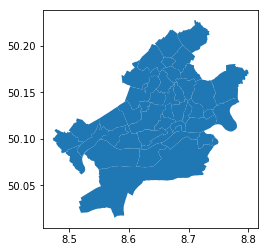

In [85]:
# Here is the plot to test the loaded information
polygons.plot()

# Methology

In this project we will direct our efforts on detecting areas of Frankfurt that have small amount of bars and a high population density.

In first step we have collected the required data: location of every bar in Frankfurt and population density for each dirstirct.

Second step in our analysis is clusterisation of the Frankfurt district based on k-means clustering. 

In the final step we will take the most promising cluster and from it top-5 district based on the amount of bars which already exists. 

# Analysis

Preparation of the dataframe/dataset for the further analysis

## Merging dataframes

Here we merge two data frames - one with the amount of bars, another one with the information about the density of the population. To do so we at first transfer the data frame with the information about the population into the dictionary

In [36]:
table_with_population=df_merge.drop(['Area (km²)','Population/10^3','Latitude','Longitude'],axis=1)

In [37]:
table_with_population.index = table_with_population['Name']

In [40]:
table_with_population=table_with_population.drop('Name', axis=1)

In [42]:
table_with_population = table_with_population.to_dict()

In [211]:
district_and_venues["Population density (Population/km²)"] = district_and_venues['Neighborhood'].apply(lambda name:table_with_population['Population density (Population/km²)'][name])

district_and_venues.head()

Neighborhood  Bars Population density (Population/km²)
0         Altstadt    26                   8409.090909090908
1  Bahnhofsviertel    31                    6832.10332103321
2   Bergen-Enkheim     1                   1427.505753511626
3       Bockenheim     9                   5247.167226995392
4          Bonames     1                   4701.166180758017

In [212]:
# We save the final table so that there is no need to parse the information again
district_and_venues.to_csv('final_table_frankfurt.csv', index = False)

In [213]:
#Here we can load the file if required
district_and_venues = pd.read_csv('final_table_frankfurt.csv', encoding = "utf-8")
district_and_venues.head()

Neighborhood  Bars  Population density (Population/km²)
0         Altstadt    26                          8409.090909
1  Bahnhofsviertel    31                          6832.103321
2   Bergen-Enkheim     1                          1427.505754
3       Bockenheim     9                          5247.167227
4          Bonames     1                          4701.166181

In [214]:
# Transfer 'Neighborhood' column to the index
district_and_venues.index = district_and_venues['Neighborhood']
district_and_venues=district_and_venues.drop('Neighborhood', axis=1)
district_and_venues.head()

Bars  Population density (Population/km²)
Neighborhood                                              
Altstadt           26                          8409.090909
Bahnhofsviertel    31                          6832.103321
Bergen-Enkheim      1                          1427.505754
Bockenheim          9                          5247.167227
Bonames             1                          4701.166181

## Normalizing over std.

For further analysis our data should be normalized

In [59]:
from sklearn.preprocessing import StandardScaler
X = district_and_venues.values[:,:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[ 1.98248141,  1.35860101],
       [ 2.49080998,  0.72647542],
       [-0.55916142, -1.43992362],
       [ 0.25416428,  0.09116373],
       [-0.55916142, -0.12769737],
       [-0.15249857,  2.41369663],
       [-0.45749571,  0.54960608],
       [-0.45749571, -0.11171932],
       [-0.55916142, -0.98803891],
       [-0.55916142, -0.63840549],
       [-0.15249857,  1.71606243],
       [-0.45749571,  0.49050289],
       [-0.45749571, -0.15968214],
       [-0.35583   , -0.49420315],
       [-0.45749571,  0.35207556],
       [-0.45749571,  0.71006734],
       [-0.35583   , -0.60800014],
       [ 3.4058014 , -0.2512139 ],
       [-0.55916142,  0.12667579],
       [-0.55916142, -1.28836368],
       [-0.15249857, -0.24204267],
       [-0.55916142, -1.11501163],
       [ 0.05083286,  1.99307434],
       [ 0.45749571,  0.13069781],
       [-0.55916142, -0.29383964],
       [-0.45749571, -0.35602642],
       [ 2.18581284,  1.09466884],
       [-0.25416428, -1.45383072],
       [-0.45749571,

## Clustering

### Choose the best k by the Elbow Method

At first, we need to find which amount of clusters we will have. To choose the best k we will follow the Elbow Method. For the information see https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

In [60]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(district_and_venues)
    Sum_of_squared_distances.append(km.inertia_)

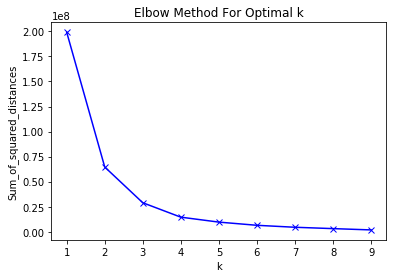

In [61]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The elbow on the arm is the optimal k. So, we will stick to k=3.

### Perform clustering

In [216]:
# Perform clustering
clusterNum = 3
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(district_and_venues)
labels = k_means.labels_
district_and_venues['Cluster'] = labels+1

In [217]:
# Shift the Cluster column in front and sort the dataframes by the Cluster value
df1 = district_and_venues.pop('Cluster')
district_and_venues.insert(loc=0, column='Cluster', value=df1)
district_and_venues=district_and_venues.sort_values('Cluster', ascending=True)
district_and_venues

Cluster  Bars  Population density (Population/km²)
Neighborhood                                                                  
Heddernheim                       1     2                          6791.169451
Ostend                            1    11                          5345.794393
Niederrad                         1     5                          4415.904637
Nied                              1     1                          5335.760518
Innenstadt                        1    40                          4393.024816
Hausen                            1     2                          5898.073836
Preungesheim                      1     1                          4286.684783
Ginnheim                          1     2                          6243.413729
Griesheim                         1     2                          4621.372549
Bonames                           1     1                          4701.166181
Bahnhofsviertel                   1    31                          6832.103321
Bockenheim                        1     9                          5247.167227
Rödelheim                         1     2                          4131.545064
Eschersheim                       1     2                          4741.027228
Eckenheim                         1     2                          6390.860692
Gutleutviertel                    2     3                          3786.830357
Sossenheim                        2     1                          2732.725122
Unterliederbach                   2     1                          2848.530144
Höchst                            2     3                          3502.936698
Fechenheim                        2     1                          2554.839633
Nieder-Eschbach                   2     1                          1805.608066
Bergen-Enkheim                    2     1                          1427.505754
Niederursel                       2     1                          2238.075990
Schwanheim                        2     4                          1392.811210
Seckbach                          2     2                          1309.288661
Frankfurter Berg                  2     1                          3427.083333
Altstadt                          3    26                          8409.090909
Nordend-Ost & Nordend-West        3     7                          9991.935484
Gallus                            3     5                          9300.863405
Bornheim                          3     5                         11041.277818
Sachsenhausen-Nord                3    28                          7750.649351
Westend-Nord & Westend-Süd        3     5                          7736.483781

Thus, the data showed 3 groups of districts:

- High population density (>7000) and average-high amount of bars (>5). 

- Low population density (<3502) and low amount of bars.

- Average population density (4000-7000) and mixed amount of bars.

This last cluster is the one we are interested in. The population density is enough to make the bar popular, however, not for all districts there is a lot of the already existing bars. So we need to extract the ones (let's say top-5) with the smalles amount of bars. Thus, we will find the districts where the bar may be popular, but will not have a lot of the high competition.

<div class="alert alert-block alert-danger">
<b>Keep in mind:</b> restarting the code may result in the different correlation between the exact number of the cluster and the description shown above
</div> 

### Extracting top-5 districts

Extracting top-5 bar districts from the interested group results in the following dataframe.

In [220]:
district_and_venues_coordinates=district_and_venues.join(df_merge.set_index('Name')[['Latitude','Longitude']])
best_matches=district_and_venues_coordinates[district_and_venues_coordinates['Cluster']==1].sort_values('Bars', ascending=True).head()
best_matches

Cluster  Bars  Population density (Population/km²)  Latitude  \
Neighborhood                                                                 
Nied                1     1                          5335.760518  50.10665   
Preungesheim        1     1                          4286.684783  50.15631   
Bonames             1     1                          4701.166181  50.18340   
Heddernheim         1     2                          6791.169451  50.16177   
Hausen              1     2                          5898.073836  50.13235   

              Longitude  
Neighborhood             
Nied            8.58209  
Preungesheim    8.69085  
Bonames         8.66456  
Heddernheim     8.64718  
Hausen          8.62337

<div class="alert alert-block alert-success">
<b>Result:</b> Thus, we found the "Preungesheim", "Nied", "Bonames", "Heddernheim" and "Hausen" districts are worth consideration for making a new bar there.
</div>

# Results and Discussion

## Visualisation of the results

We display the clusters with different colors on the map

In [236]:
map_clusters = folium.Map(location=[latitude_frankfurt, longitude_frankfurt], zoom_start=11)
kclusters=clusterNum
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.plasma(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(district_and_venues_coordinates['Latitude'], district_and_venues_coordinates['Longitude'], district_and_venues_coordinates.index, district_and_venues_coordinates['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    cluster=int(cluster)
    folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Then we show our top-5 neighborhoods for the new pub

In [237]:
# create map of Frankfurt using latitude and longitude values
map_frankfurt = folium.Map(location=[latitude_frankfurt, longitude_frankfurt], zoom_start=11)

# add markers to map
for lat, lng, name in zip(best_matches['Latitude'], best_matches['Longitude'], best_matches.index):
    label = '{} '.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_frankfurt)  
    
map_frankfurt

As was discussed previously, we can also plot Frankfurt districts as the polygons and put our best matches on the top of it for fancier visualisation.

In [238]:
m = folium.Map(location=[latitude_frankfurt, longitude_frankfurt], zoom_start=11)
for _, r in polygons.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(_).add_to(geo_j)
    geo_j.add_to(m)
for _, r in best_matches.iterrows():
    label = '{} '.format(_)
    lat = r['Latitude']
    lon = r['Longitude']
    
    folium.Marker(location=[lat, lon],
                  popup=label).add_to(m)

m

Here I upload the printscreen of the above map, so that it can be visible without the code execution.

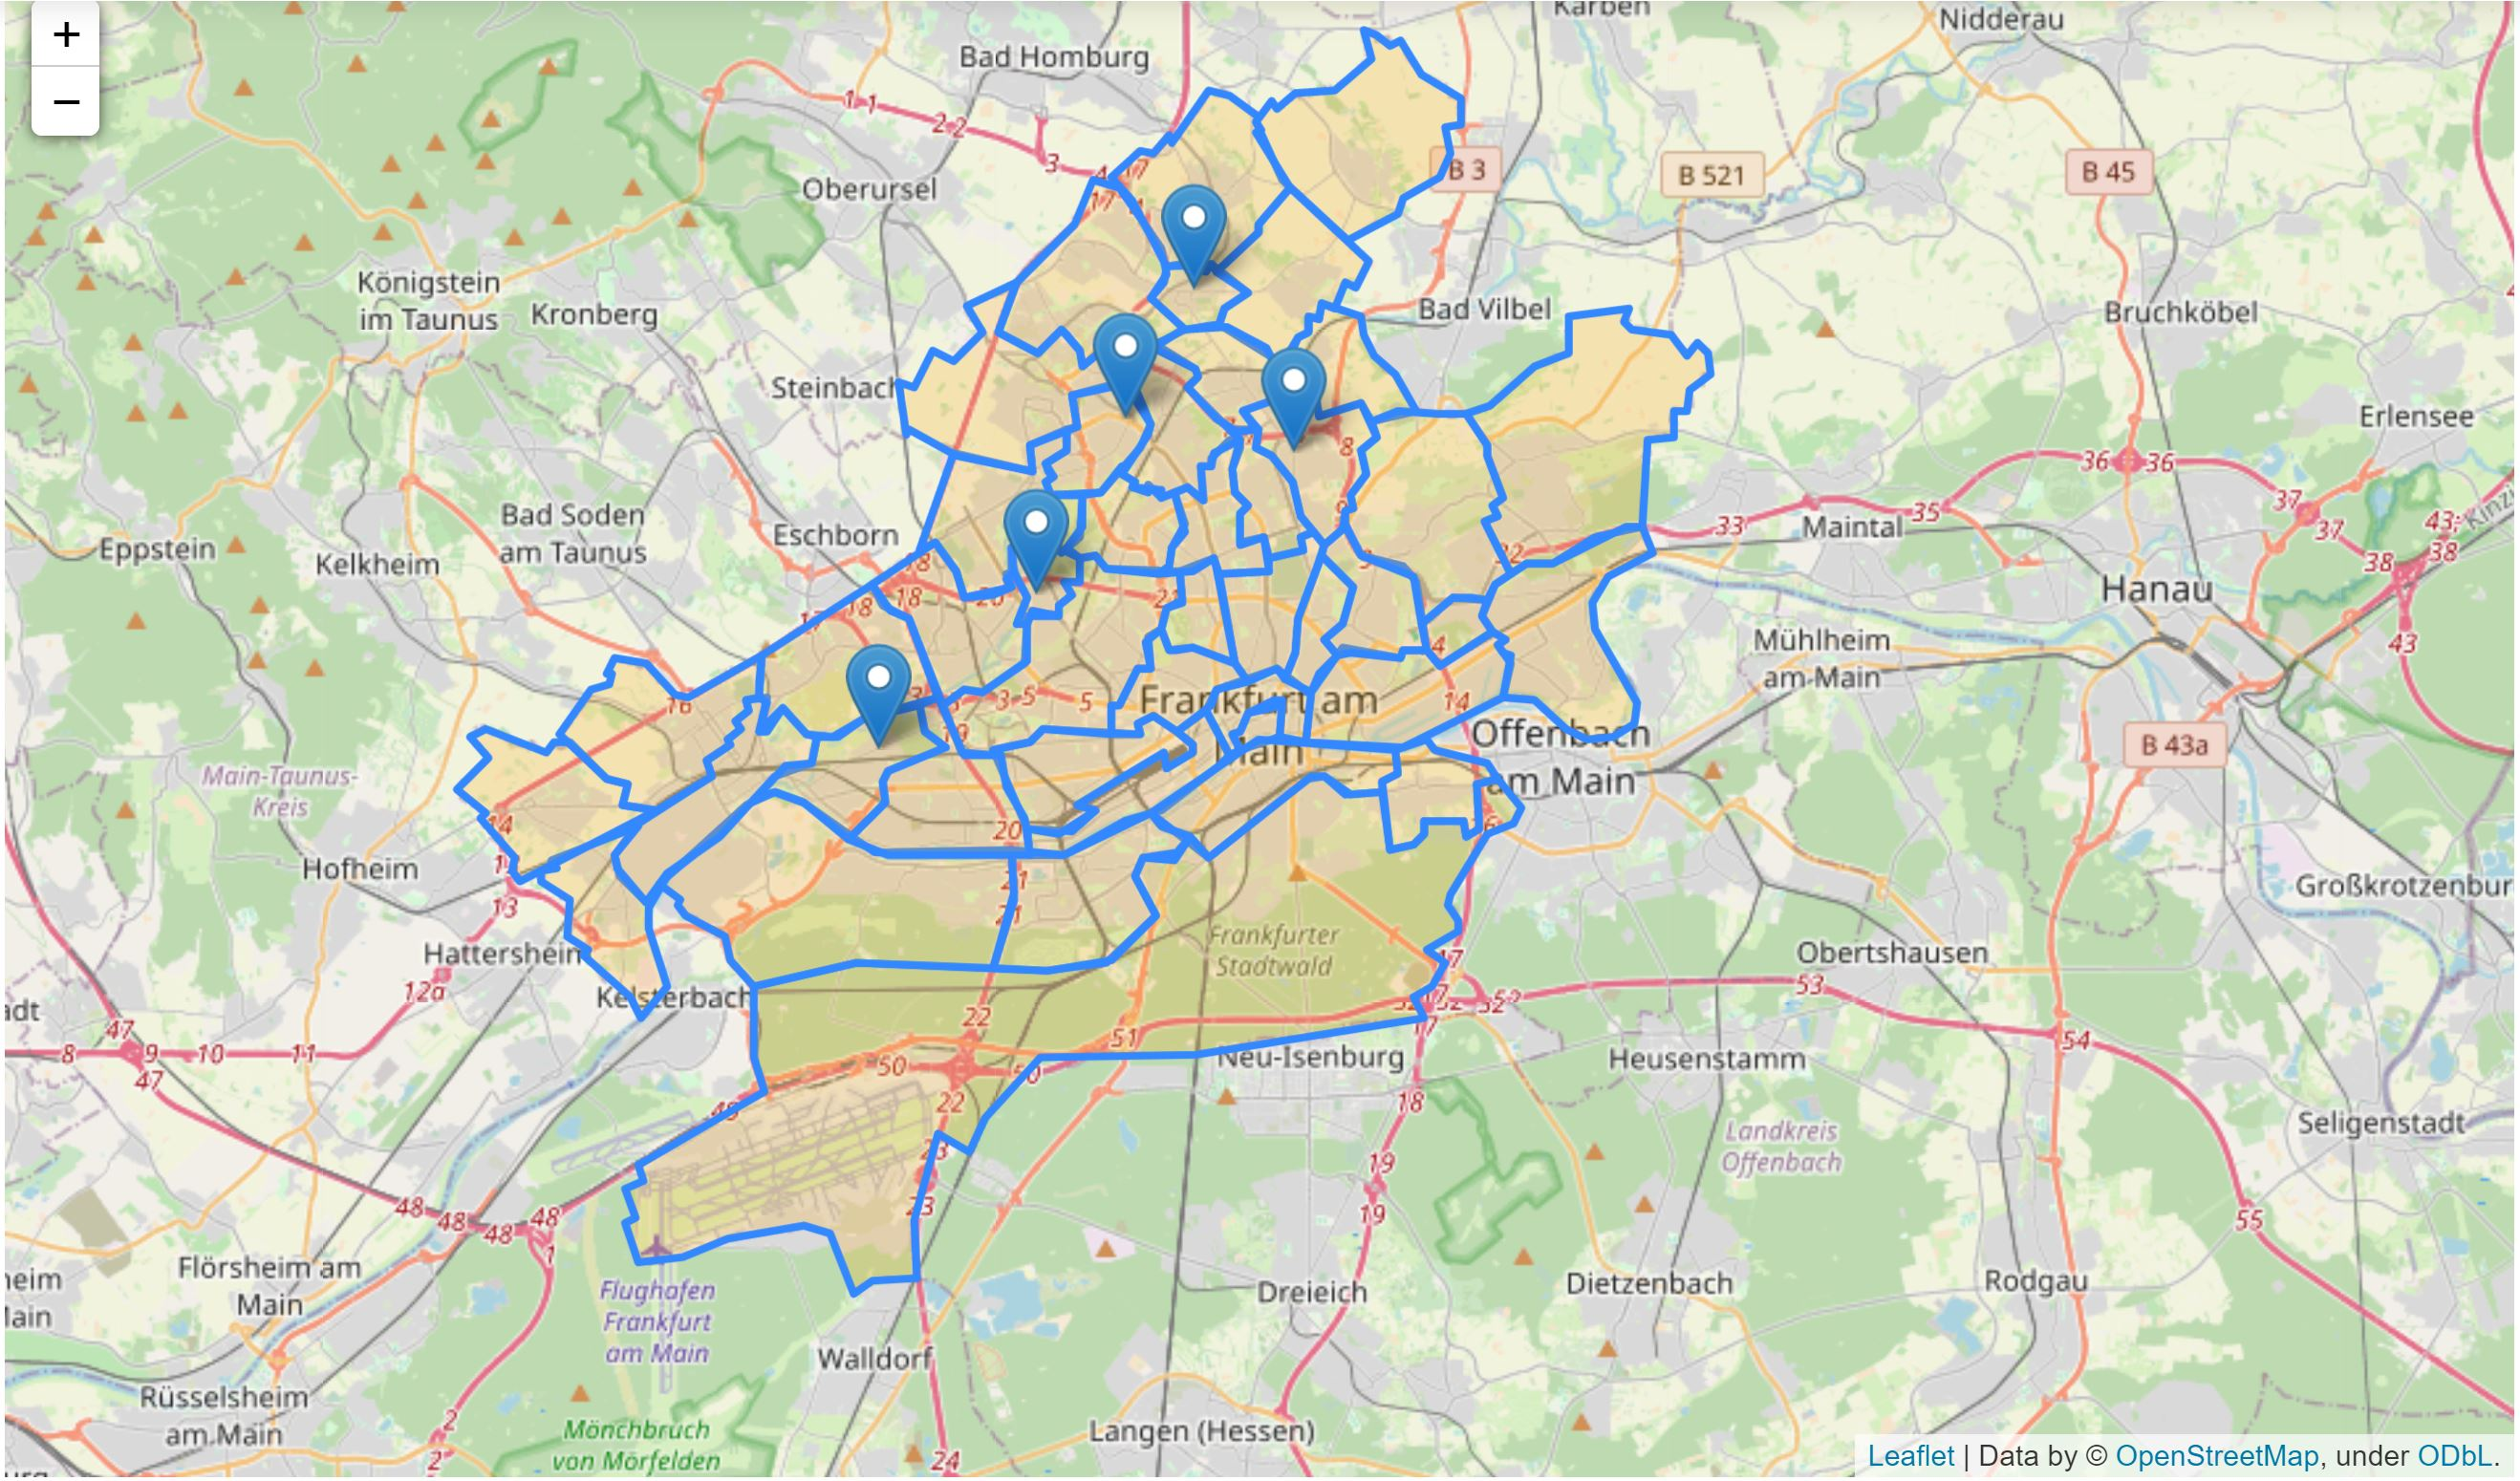

In [240]:
from PIL import Image
img = Image.open('frankfurt_map_2.JPG')
img

## Discussion

Our analysis shows that surprisingly there is a relative small amount of bars in Frankfurt: only 208 in the whole area, baring in mind that Frankfurt is one of the largest cities in Germany. The districts can be devided in 3 categories.

- High population density (>7000) and average-high amount of bars (>5). 

- Low population density (<3502) and low amount of bars.

- Average population density (4000-7000) and mixed amount of bars.

Investigation of the map shows that the first category disrticts are located near the city center. Thus, the amount of pubs is high due to the tourist attraction to this location and other advantages of the city center. 

The second custer (low density and low amount of bars) is located in the city perephery. 

The final cluster is the most promising. The population density is enough to make the bar popular, however, not for all districts there is a lot of the already existing bars. 

Exctracting top-5 districts with the smallest amount of bars from this cluster allows us to find perfect candidated for the consideration for the new bars. Recommended zones should therefore be considered only as a starting point for more detailed analysis which could eventually result in location which has not only no nearby competition but also other factors taken into account and all other relevant conditions met.

# Conclusions

Purpose of this project was to identify Frankfurt areas with low number of bars in order to aid stakeholders in narrowing down the search for optimal location for a new bar. By calculating amount of bars from Foursquare data and merging this information with the density population data we prepared the dataset for further consideration. Clustering of those locations was then performed in order to create major zones of interest. Thus, we found the "Preungesheim", "Nied", "Bonames", "Heddernheim" and "Hausen" districts are worth consideration for making a new bar there.

Final decission on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.